In [1]:
import pickle
# gensim
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
# logging for gensim (set to INFO)
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import pyLDAvis
import os
import gensim
import pyLDAvis.gensim

In [680]:
with open("zillow_df.pkl", 'rb') as picklefile: 
    df = pickle.load(picklefile)

In [681]:
df.head()

,address,city,state,zip,price,sqft,bedrooms,bathrooms,days_on_zillow,sale_type,url,description
0,20014 59th Ave SE,Snohomish,WA,98296,1868000,7359,4,6,NA,House For Sale,http://www.zillow.com/homes/for_sale//homedeta...,Walk-through Video: www.seetheproperty.com/250...
1,13506 70th Dr SE,Snohomish,WA,98296,674950,2957,4,3,3,House For Sale,http://www.zillow.com/homes/for_sale//homedeta...,Wonderful Highlands East home that has been up...
2,14313 214th St SE,Snohomish,WA,98296,546000,2237,3,3,6,Auction,http://www.zillow.com/homes/for_sale//homedeta...,Investor opportunity! This property is being o...
3,11621 60th Ave SE,Snohomish,WA,98296,489950,2213,4,3,4,House For Sale,http://www.zillow.com/homes/for_sale//homedeta...,"Newer 4 br, 2.5 bths 2-story backs to greenbel..."
4,13325 81st Ave SE,Snohomish,WA,98296,720000,3091,4,3,12,House For Sale,http://www.zillow.com/homes/for_sale//homedeta...,Beautiful Murray Franklin re-sale in the desir...


In [682]:
desc = df['description']

In [683]:
desc[0]

"Walk-through Video: www.seetheproperty.com/250910    Just a hop over the border to Snohomish County, but still in Northshore School District! A meandering driveway is the grand approach to this superbly-built 5832 sq ft home with 1527 sq ft guest house/apartment, that will make every covered porch-lovers heart skip a beat. Enjoy country living with elegance and charm, in a pastoral setting. A stroll around the shy 5-acre parcel reveals surprises, too, including an outdoor fireplace, sport court, and a barn equipped with chandeliers, perfect for a large gathering or for your mini-farm. The main home has 4 bedrooms + bonus + a finished room with closet (alternate bedroom). The apartment has 3 finished rooms that can be used as bedrooms. There's also a basement level workout room and storage roomExcellent for VRBO, Airbnb or potential retreat/event center.Convenient location is close to Woodinville, Canyon Park and Seattle.Just a few minutes to Costco and Woodinville's Brightwater Park, 

In [684]:
word_count = []
for doc in desc:
    word_count.append(len(doc.split()))

In [685]:
df['word_count'] = word_count

In [686]:
df.head()

,address,city,state,zip,price,sqft,bedrooms,bathrooms,days_on_zillow,sale_type,url,description,word_count
0,20014 59th Ave SE,Snohomish,WA,98296,1868000,7359,4,6,NA,House For Sale,http://www.zillow.com/homes/for_sale//homedeta...,Walk-through Video: www.seetheproperty.com/250...,209
1,13506 70th Dr SE,Snohomish,WA,98296,674950,2957,4,3,3,House For Sale,http://www.zillow.com/homes/for_sale//homedeta...,Wonderful Highlands East home that has been up...,91
2,14313 214th St SE,Snohomish,WA,98296,546000,2237,3,3,6,Auction,http://www.zillow.com/homes/for_sale//homedeta...,Investor opportunity! This property is being o...,187
3,11621 60th Ave SE,Snohomish,WA,98296,489950,2213,4,3,4,House For Sale,http://www.zillow.com/homes/for_sale//homedeta...,"Newer 4 br, 2.5 bths 2-story backs to greenbel...",79
4,13325 81st Ave SE,Snohomish,WA,98296,720000,3091,4,3,12,House For Sale,http://www.zillow.com/homes/for_sale//homedeta...,Beautiful Murray Franklin re-sale in the desir...,54


In [ ]:
from glob import glob
import re
import string
import funcy as fp
from gensim import models
from itertools import chain
from gensim.corpora import Dictionary, MmCorpus
import nltk
import pandas as pd

In [688]:
nltk_stopwords = stopwords.words("english")+["lots", "home", "love", "room", "ft", "e", "3",
                                             "foot", "square foot", "com", "search", "details",
                                             "large", "main", "area", "space", "floor", "2.0",
                                             "located", "enjoy", "one", "easy", "se", "-", "st"
                                             "location", "property", "properties", "throughout",
                                             "including", "features","also", "many", "offer",
                                             "available", "like", "currently", "ready", "time",
                                             "bonus", "come", "information", "calisto", "less",
                                             "selected", "westridge", "square", "found", "see",
                                             "additional", "homes", "find","sale", "sales",
                                             "design", "&", "ave", "2", "car", "4", "5", "w/", "1"]

In [689]:
# remove common words and tokenize
texts = [[word for word in document.lower().split() if word not in nltk_stopwords]
         for document in desc]
# remove words that appear only once
all_tokens = sum(texts, [])
tokens_once = set(word for word in set(all_tokens) if all_tokens.count(word) == 1)
texts = [[word for word in text if word not in tokens_once] for text in texts]

# Create Dictionary.
id2word = corpora.Dictionary(texts)
# Creates the Bag of Word corpus.
mm = [id2word.doc2bow(text) for text in texts]
ntopics = 6
# Trains the LDA models.
lda = models.ldamodel.LdaModel(corpus=mm, id2word=id2word, num_topics=ntopics, \
                               minimum_probability=.03, passes=8, random_state = 100)

# Prints the topics.
for top in lda.print_topics():
    print (top)


# Assigns the topics to the documents in corpus
lda_corpus = lda[mm]

# Find the threshold, let's set the threshold to be 1/#clusters,
# To prove that the threshold is sane, we average the sum of all probabilities:
scores = list(chain(*[[score for topic_id,score in topic] \
                      for topic in [doc for doc in lda_corpus]]))
threshold = sum(scores)/len(scores)
print (threshold)


2018-03-08 16:10:32,969 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-03-08 16:10:33,118 : INFO : built Dictionary(8183 unique tokens: ['+', '5-acre', 'airbnb', 'apartment', 'approach']...) from 2639 documents (total 122836 corpus positions)
2018-03-08 16:10:33,246 : INFO : using symmetric alpha at 0.16666666666666666
2018-03-08 16:10:33,247 : INFO : using symmetric eta at 0.16666666666666666
2018-03-08 16:10:33,250 : INFO : using serial LDA version on this node
2018-03-08 16:10:33,496 : INFO : running online (multi-pass) LDA training, 6 topics, 8 passes over the supplied corpus of 2639 documents, updating model once every 2000 documents, evaluating perplexity every 2639 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-08 16:10:33,497 : INFO : PROGRESS: pass 0, at document #2000/2639
2018-03-08 16:10:36,841 : INFO : merging changes from 2000 documents into a model of 2639 documents
2018-03-08 16:10:36,967 : INFO : topic #1 (0.167): 0.012*"

2018-03-08 16:10:48,671 : INFO : topic #4 (0.167): 0.019*"new" + 0.010*"lot" + 0.008*"great" + 0.006*"beautiful" + 0.006*"water" + 0.006*"living" + 0.006*"close" + 0.005*"kitchen" + 0.005*"master" + 0.005*"lake"
2018-03-08 16:10:48,673 : INFO : topic #1 (0.167): 0.013*"kitchen" + 0.013*"master" + 0.012*"new" + 0.008*"bath" + 0.008*"open" + 0.007*"great" + 0.007*"gas" + 0.007*"dining" + 0.006*"custom" + 0.006*"tile"
2018-03-08 16:10:48,675 : INFO : topic #3 (0.167): 0.024*"family" + 0.024*"bedrooms" + 0.024*"single" + 0.023*"washington." + 0.022*"bathrooms." + 0.009*"home." + 0.009*"land" + 0.008*"last" + 0.008*"tax" + 0.007*"st"
2018-03-08 16:10:48,677 : INFO : topic #0 (0.167): 0.036*"auction.com" + 0.026*"foreclosure" + 0.019*"property," + 0.017*"scheduled" + 0.010*"priced" + 0.010*"county" + 0.010*"looking" + 0.010*"investment" + 0.010*"opportunity" + 0.010*"view"
2018-03-08 16:10:48,678 : INFO : topic diff=0.433330, rho=0.481153
2018-03-08 16:10:48,680 : INFO : PROGRESS: pass 3, at

2018-03-08 16:10:59,801 : INFO : topic #4 (0.167): 0.021*"new" + 0.012*"lot" + 0.008*"great" + 0.007*"water" + 0.007*"beautiful" + 0.006*"close" + 0.006*"lake" + 0.005*"build" + 0.004*"living" + 0.004*"community"
2018-03-08 16:10:59,803 : INFO : topic #2 (0.167): 0.009*"great" + 0.009*"kitchen" + 0.008*"living" + 0.008*"master" + 0.007*"open" + 0.006*"close" + 0.005*"back" + 0.005*"bedroom" + 0.005*"private" + 0.005*"beautiful"
2018-03-08 16:10:59,804 : INFO : topic #1 (0.167): 0.017*"master" + 0.016*"kitchen" + 0.011*"new" + 0.009*"open" + 0.009*"bath" + 0.008*"dining" + 0.008*"gas" + 0.008*"great" + 0.007*"living" + 0.007*"suite"
2018-03-08 16:10:59,806 : INFO : topic #3 (0.167): 0.026*"bedrooms" + 0.026*"family" + 0.026*"single" + 0.026*"washington." + 0.025*"bathrooms." + 0.011*"land" + 0.010*"home." + 0.009*"vacant" + 0.009*"last" + 0.009*"tax"
2018-03-08 16:10:59,808 : INFO : topic #5 (0.167): 0.008*"lot" + 0.007*"great" + 0.006*"living" + 0.005*"private" + 0.005*"acres" + 0.005*

(0, '0.038*"auction.com" + 0.028*"foreclosure" + 0.020*"property," + 0.018*"scheduled" + 0.011*"county" + 0.011*"looking" + 0.011*"investment" + 0.011*"buy" + 0.011*"opportunity!" + 0.011*"investor"')
(1, '0.018*"master" + 0.017*"kitchen" + 0.011*"new" + 0.010*"open" + 0.009*"bath" + 0.009*"dining" + 0.008*"gas" + 0.008*"great" + 0.008*"living" + 0.007*"suite"')
(2, '0.009*"living" + 0.009*"great" + 0.009*"kitchen" + 0.008*"master" + 0.007*"open" + 0.006*"close" + 0.005*"back" + 0.005*"bedroom" + 0.005*"fenced" + 0.005*"walk"')
(3, '0.027*"bedrooms" + 0.027*"family" + 0.027*"single" + 0.026*"washington." + 0.026*"bathrooms." + 0.011*"land" + 0.010*"home." + 0.010*"vacant" + 0.009*"last" + 0.008*"tax"')
(4, '0.022*"new" + 0.012*"lot" + 0.008*"great" + 0.008*"water" + 0.007*"beautiful" + 0.006*"close" + 0.006*"lake" + 0.005*"build" + 0.005*"community" + 0.004*"access"')
(5, '0.009*"lot" + 0.007*"great" + 0.006*"acres" + 0.006*"acre" + 0.005*"private" + 0.005*"two" + 0.005*"view" + 0.005*

In [690]:
len(scores)

6262

In [691]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
data_viz = pyLDAvis.gensim.prepare(lda, lda_corpus, id2word, mds='mmds')#mds = 'mmds'
pyLDAvis.display(data_viz)

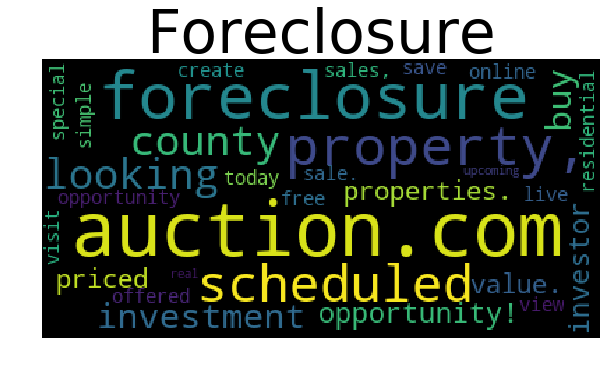

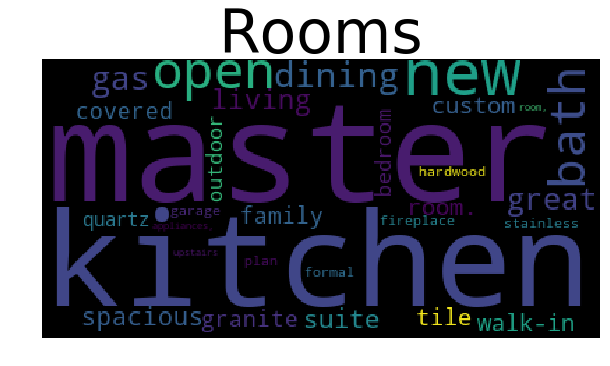

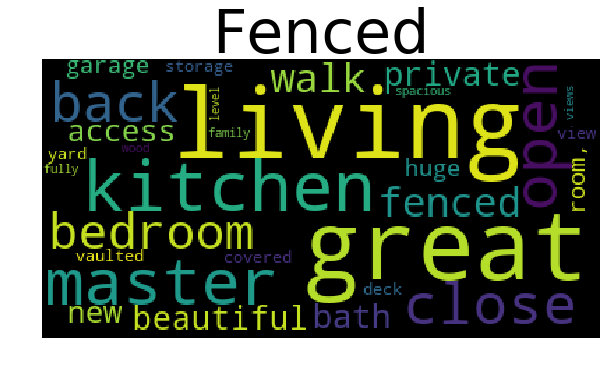

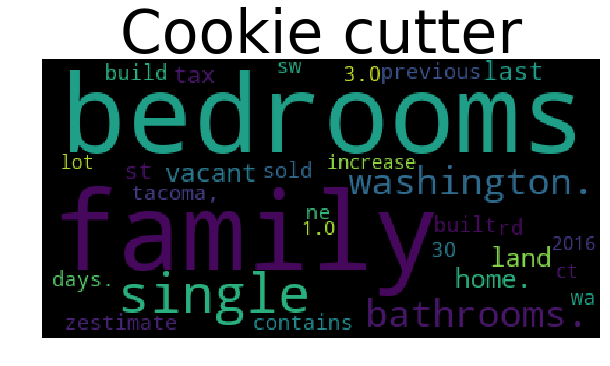

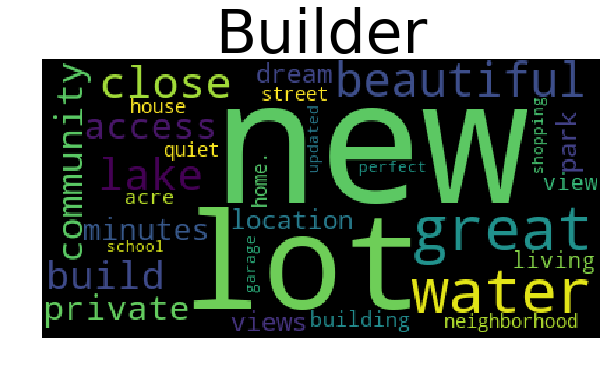

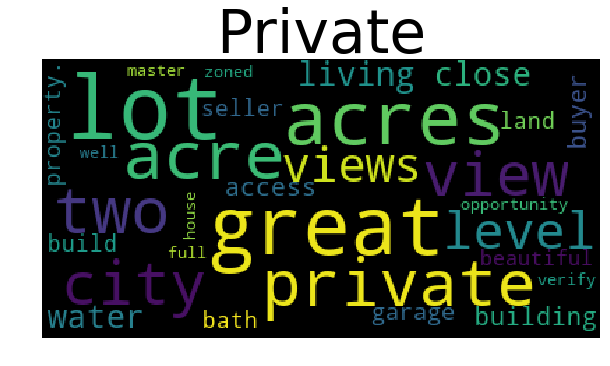

In [692]:
num_words = 30 # Number of words to include in word cloud
names = ['Foreclosure', 'Rooms', 'Fenced', 'Cookie cutter', 'Builder', 'Private']
for t in range(lda.num_topics):
    plt.figure(figsize=(10,8))
    plt.imshow(WordCloud().fit_words(dict(lda.show_topic(t, num_words))))
    
    plt.axis("off")
    plt.title(names[t], fontsize = 60)
    plt.show()

## Topic Names:

1 = foreclosure

2 = rooms

3 = fenced

4 = cookie cutter

5 = builder

6 = private

In [693]:
topic_prob = [doc for doc in lda_corpus]

In [694]:
topic_list = []
i = 0
for doc in topic_prob:
    p_old = 0
    for topic in doc:
        t = topic[0]
        p = topic[1]
        if p > p_old:
            p_old = p
            t_take = t
    topic_list.append(t_take)

In [695]:
df_0 = df

In [696]:
df_0['topic'] = topic_list

In [697]:
df_0[['price', 'sqft', 'bedrooms', 'bathrooms','days_on_zillow']] = df_0[['price', 'sqft', 'bedrooms', 'bathrooms','days_on_zillow']].apply(pd.to_numeric, errors = 'coerce')

In [698]:
df_0.fillna(0, inplace=True)

In [699]:
df_0_means = df_0.groupby('topic').mean()
df_0_means.price

topic
0    316910.722892
1    795728.130548
2    860658.255294
3    741012.300000
4    626431.045537
5    783764.700368
Name: price, dtype: float64

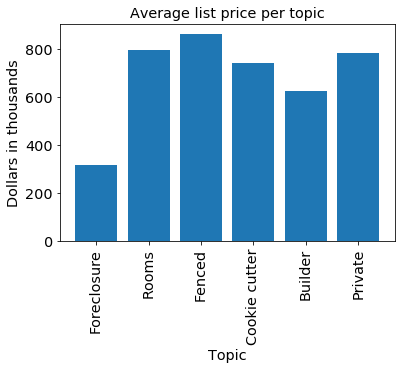

In [700]:
# barplot of marriage rating grouped by affair (True or False)
plt.bar(range(ntopics), df_0_means.price/1000)
plt.title('Average list price per topic')
plt.xlabel('Topic')
plt.ylabel('Dollars in thousands')
plt.xticks(range(ntopics), names, rotation='vertical');

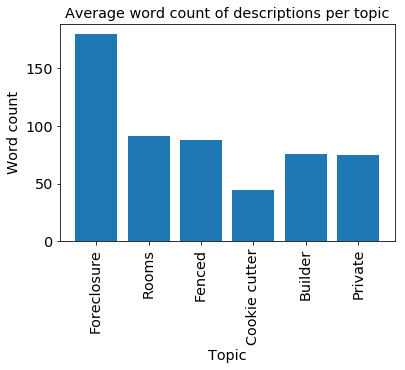

In [701]:
# barplot of marriage rating grouped by affair (True or False)
plt.bar(range(ntopics), df_0_means.word_count)
plt.title('Average word count of descriptions per topic')
plt.xlabel('Topic')
plt.ylabel('Word count')
plt.xticks(range(ntopics), names, rotation='vertical');

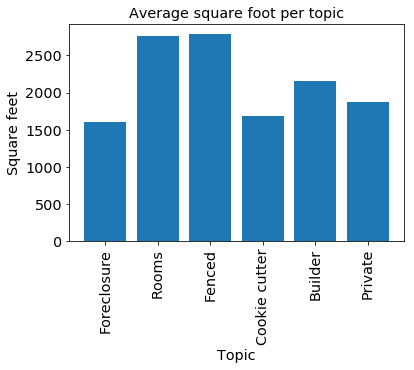

In [702]:
# barplot of marriage rating grouped by affair (True or False)
plt.bar(range(ntopics), df_0_means.sqft)
plt.title('Average square foot per topic')
plt.xlabel('Topic')
plt.ylabel('Square feet')
plt.xticks(range(ntopics), names, rotation='vertical');

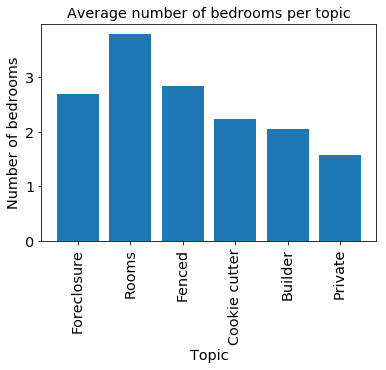

In [703]:
# barplot of marriage rating grouped by affair (True or False)
plt.bar(range(ntopics), df_0_means.bedrooms)
plt.title('Average number of bedrooms per topic')
plt.xlabel('Topic')
plt.ylabel('Number of bedrooms')
plt.xticks(range(ntopics), names, rotation='vertical');

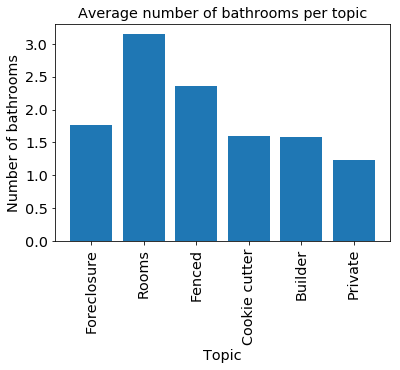

In [704]:
# barplot of marriage rating grouped by affair (True or False)
plt.bar(range(ntopics), df_0_means.bathrooms)
plt.title('Average number of bathrooms per topic')
plt.xlabel('Topic')
plt.ylabel('Number of bathrooms')
plt.xticks(range(ntopics), names, rotation='vertical');

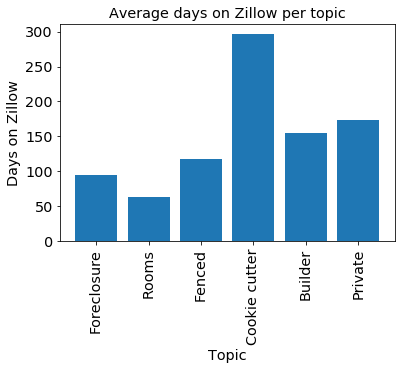

In [705]:
# barplot of marriage rating grouped by affair (True or False)
plt.bar(range(ntopics), df_0_means.days_on_zillow)
plt.title('Average days on Zillow per topic')
plt.xlabel('Topic')
plt.ylabel('Days on Zillow')
plt.xticks(range(ntopics), names, rotation='vertical');

In [706]:
counts = df_0.groupby('topic')['description'].count()

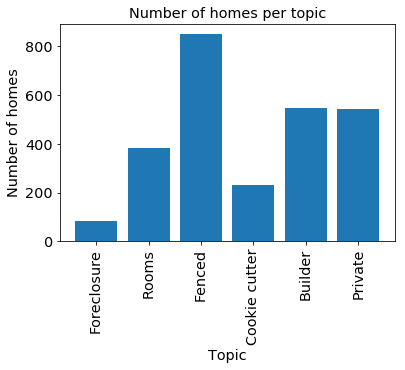

In [707]:
# barplot of marriage rating grouped by affair (True or False)
plt.bar(range(ntopics), counts)
plt.title('Number of homes per topic')
plt.xlabel('Topic')
plt.ylabel('Number of homes')
plt.xticks(range(ntopics), names, rotation='vertical');

I want to remove some of the over used or meaningless words like "great", "lots", "home", "love", "room", "ft", "foot", "square foot", "com", "search", "details", "large", "perfect", "main", "area", "space", "floor", "located", "beautiful", "enjoy", "one", "easy", "location", "property", "properties", "throughout", "including", "features", "also", "many", "offer", "available", "like", "currently", "ready", "time", "bonus", "come", "information", "calisto", "less", "selected", "westridge", "square", "found", "see", "additional", "homes", "find", "sale", "sales", "design".

In [708]:
nltk_stopwords = stopwords.words("english")+["great", "lots", "home", "love", "room", "ft",
                                             "foot", "square foot", "com", "search", "details",
                                             "large", "perfect", "main", "area", "space", "floor",
                                             "located", "beautiful", "enjoy", "one", "easy",
                                             "location", "property", "properties", "throughout",
                                             "including", "features","also", "many", "offer",
                                             "available", "like", "currently", "ready", "time",
                                             "bonus", "come", "information", "calisto", "less",
                                             "selected", "westridge", "square", "found", "see",
                                             "additional", "homes", "find","sale", "sales",
                                             "design"]

In [709]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2), 
                                   stop_words=nltk_stopwords,
                                   token_pattern="\\b[a-z][a-z]+\\b")
count_vectorizer.fit(desc)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',...d', 'westridge', 'square', 'found', 'see', 'additional', 'homes', 'find', 'sale', 'sales', 'design'],
        strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
        tokenizer=None, vocabulary=None)

In [710]:
counts = count_vectorizer.transform(desc).transpose()

In [711]:
counts.shape

(76717, 2639)

In [712]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(counts)

In [713]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [714]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=ntopics, minimum_probability=.03, id2word=id2word, passes=10, random_state = 100)

2018-03-08 16:11:20,332 : INFO : using symmetric alpha at 0.16666666666666666
2018-03-08 16:11:20,335 : INFO : using symmetric eta at 0.16666666666666666
2018-03-08 16:11:20,352 : INFO : using serial LDA version on this node
2018-03-08 16:11:22,568 : INFO : running online (multi-pass) LDA training, 6 topics, 10 passes over the supplied corpus of 2639 documents, updating model once every 2000 documents, evaluating perplexity every 2639 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-08 16:11:22,621 : INFO : PROGRESS: pass 0, at document #2000/2639
2018-03-08 16:11:25,979 : INFO : merging changes from 2000 documents into a model of 2639 documents
2018-03-08 16:11:26,372 : INFO : topic #3 (0.167): 0.005*"kitchen" + 0.005*"master" + 0.004*"new" + 0.003*"living" + 0.003*"open" + 0.003*"deck" + 0.003*"bath" + 0.003*"level" + 0.003*"views" + 0.003*"walk"
2018-03-08 16:11:26,375 : INFO : topic #5 (0.167): 0.004*"lot" + 0.004*"bath" + 0.003*"kitchen" + 0.003*"bedroom" 

2018-03-08 16:11:43,682 : INFO : topic #4 (0.167): 0.005*"bedrooms" + 0.004*"family" + 0.004*"new" + 0.004*"bathrooms" + 0.004*"washington" + 0.003*"bedrooms bathrooms" + 0.003*"single" + 0.003*"single family" + 0.003*"family bedrooms" + 0.002*"park"
2018-03-08 16:11:43,685 : INFO : topic #5 (0.167): 0.006*"lot" + 0.003*"water" + 0.003*"acres" + 0.003*"build" + 0.003*"acre" + 0.002*"building" + 0.002*"opportunity" + 0.002*"dream" + 0.002*"private" + 0.002*"land"
2018-03-08 16:11:43,689 : INFO : topic #2 (0.167): 0.006*"kitchen" + 0.004*"new" + 0.004*"living" + 0.004*"master" + 0.004*"bath" + 0.004*"garage" + 0.003*"open" + 0.003*"dining" + 0.003*"spacious" + 0.003*"bedroom"
2018-03-08 16:11:43,693 : INFO : topic diff=0.348991, rho=0.481153
2018-03-08 16:11:43,762 : INFO : PROGRESS: pass 3, at document #2000/2639
2018-03-08 16:11:46,445 : INFO : merging changes from 2000 documents into a model of 2639 documents
2018-03-08 16:11:47,512 : INFO : topic #0 (0.167): 0.015*"auction" + 0.006*"

2018-03-08 16:12:00,193 : INFO : topic #1 (0.167): 0.006*"lot" + 0.004*"water" + 0.003*"street" + 0.003*"close" + 0.003*"acre" + 0.003*"new" + 0.003*"acres" + 0.003*"build" + 0.002*"access" + 0.002*"view"
2018-03-08 16:12:00,196 : INFO : topic #3 (0.167): 0.008*"kitchen" + 0.007*"master" + 0.006*"bath" + 0.006*"new" + 0.005*"living" + 0.004*"walk" + 0.004*"open" + 0.004*"deck" + 0.004*"suite" + 0.003*"dining"
2018-03-08 16:12:00,199 : INFO : topic #4 (0.167): 0.005*"bedrooms" + 0.004*"family" + 0.004*"new" + 0.004*"bathrooms" + 0.004*"washington" + 0.004*"bedrooms bathrooms" + 0.003*"single" + 0.003*"single family" + 0.003*"family bedrooms" + 0.002*"park"
2018-03-08 16:12:00,202 : INFO : topic #0 (0.167): 0.018*"auction" + 0.008*"foreclosure" + 0.006*"opportunity" + 0.005*"scheduled" + 0.004*"washington" + 0.003*"county" + 0.003*"view" + 0.003*"complete" + 0.003*"bank" + 0.003*"residential"
2018-03-08 16:12:00,205 : INFO : topic diff=0.163399, rho=0.369623
2018-03-08 16:12:00,260 : INF

2018-03-08 16:12:12,038 : INFO : merging changes from 639 documents into a model of 2639 documents
2018-03-08 16:12:12,184 : INFO : topic #3 (0.167): 0.009*"kitchen" + 0.007*"master" + 0.006*"bath" + 0.006*"new" + 0.005*"living" + 0.004*"walk" + 0.004*"open" + 0.004*"deck" + 0.004*"suite" + 0.003*"dining"
2018-03-08 16:12:12,186 : INFO : topic #1 (0.167): 0.007*"lot" + 0.004*"water" + 0.003*"street" + 0.003*"close" + 0.003*"acre" + 0.003*"build" + 0.003*"acres" + 0.003*"new" + 0.002*"view" + 0.002*"access"
2018-03-08 16:12:12,189 : INFO : topic #5 (0.167): 0.007*"lot" + 0.004*"water" + 0.003*"acres" + 0.003*"build" + 0.003*"building" + 0.003*"acre" + 0.002*"views" + 0.002*"dream" + 0.002*"opportunity" + 0.002*"lake"
2018-03-08 16:12:12,192 : INFO : topic #0 (0.167): 0.019*"auction" + 0.008*"foreclosure" + 0.006*"opportunity" + 0.005*"scheduled" + 0.004*"washington" + 0.003*"county" + 0.003*"view" + 0.003*"complete" + 0.003*"live" + 0.003*"residential"
2018-03-08 16:12:12,195 : INFO : t

In [715]:
lda.print_topics()

2018-03-08 16:12:16,162 : INFO : topic #0 (0.167): 0.019*"auction" + 0.008*"foreclosure" + 0.006*"opportunity" + 0.005*"scheduled" + 0.004*"washington" + 0.003*"county" + 0.003*"view" + 0.003*"complete" + 0.003*"live" + 0.003*"residential"
2018-03-08 16:12:16,168 : INFO : topic #1 (0.167): 0.007*"lot" + 0.004*"water" + 0.003*"street" + 0.003*"close" + 0.003*"acre" + 0.003*"build" + 0.003*"acres" + 0.003*"new" + 0.002*"view" + 0.002*"access"
2018-03-08 16:12:16,172 : INFO : topic #2 (0.167): 0.005*"kitchen" + 0.004*"new" + 0.004*"living" + 0.004*"master" + 0.003*"bath" + 0.003*"garage" + 0.003*"open" + 0.003*"dining" + 0.003*"spacious" + 0.002*"views"
2018-03-08 16:12:16,175 : INFO : topic #3 (0.167): 0.009*"kitchen" + 0.007*"master" + 0.006*"bath" + 0.006*"new" + 0.005*"living" + 0.004*"walk" + 0.004*"open" + 0.004*"deck" + 0.004*"suite" + 0.004*"garage"
2018-03-08 16:12:16,180 : INFO : topic #4 (0.167): 0.005*"bedrooms" + 0.004*"family" + 0.004*"bathrooms" + 0.004*"washington" + 0.004

[(0,
  '0.019*"auction" + 0.008*"foreclosure" + 0.006*"opportunity" + 0.005*"scheduled" + 0.004*"washington" + 0.003*"county" + 0.003*"view" + 0.003*"complete" + 0.003*"live" + 0.003*"residential"'),
 (1,
  '0.007*"lot" + 0.004*"water" + 0.003*"street" + 0.003*"close" + 0.003*"acre" + 0.003*"build" + 0.003*"acres" + 0.003*"new" + 0.002*"view" + 0.002*"access"'),
 (2,
  '0.005*"kitchen" + 0.004*"new" + 0.004*"living" + 0.004*"master" + 0.003*"bath" + 0.003*"garage" + 0.003*"open" + 0.003*"dining" + 0.003*"spacious" + 0.002*"views"'),
 (3,
  '0.009*"kitchen" + 0.007*"master" + 0.006*"bath" + 0.006*"new" + 0.005*"living" + 0.004*"walk" + 0.004*"open" + 0.004*"deck" + 0.004*"suite" + 0.004*"garage"'),
 (4,
  '0.005*"bedrooms" + 0.004*"family" + 0.004*"bathrooms" + 0.004*"washington" + 0.004*"new" + 0.004*"bedrooms bathrooms" + 0.004*"single" + 0.003*"single family" + 0.003*"family bedrooms" + 0.002*"park"'),
 (5,
  '0.007*"lot" + 0.004*"water" + 0.003*"acres" + 0.003*"build" + 0.003*"build

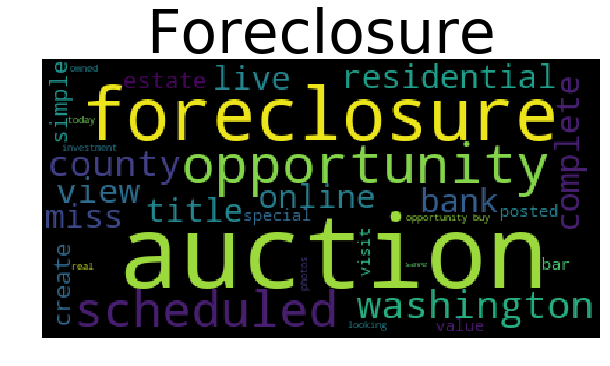

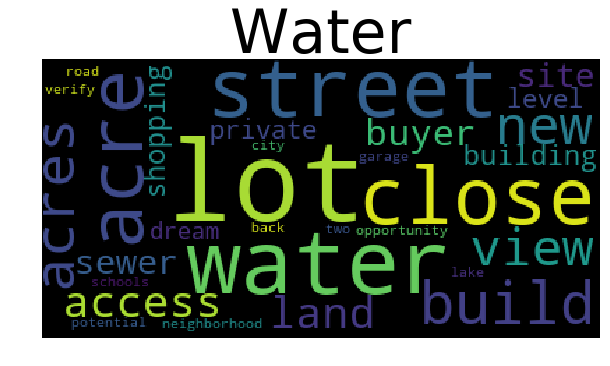

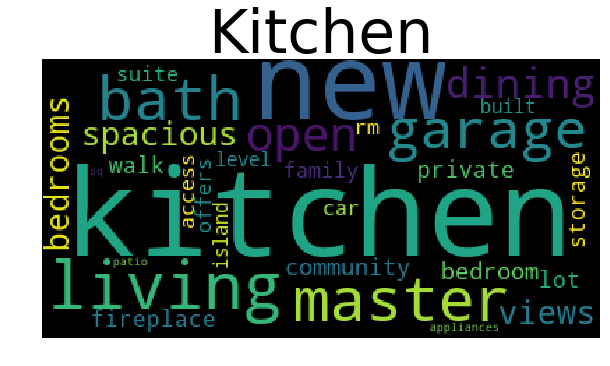

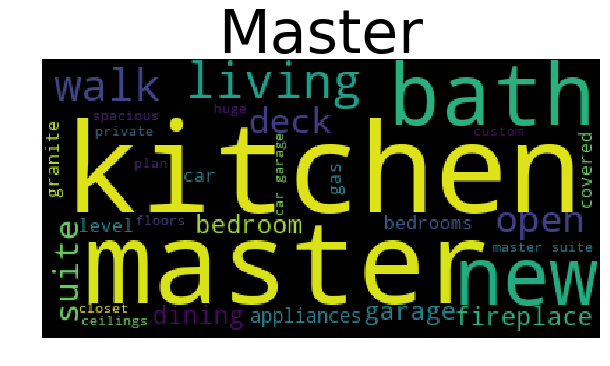

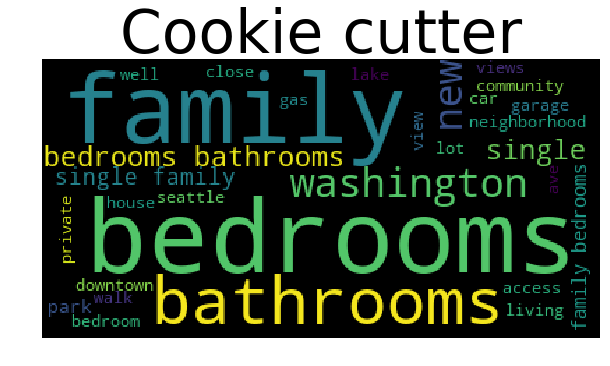

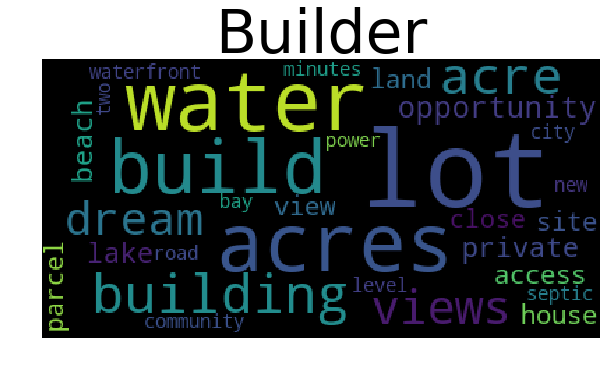

In [716]:
num_words = 30 # Number of words to include in word cloud
names = ['Foreclosure', 'Water', 'Kitchen', 'Master', 'Cookie cutter', 'Builder']
for t in range(lda.num_topics):
    plt.figure(figsize=(10,8))
    plt.imshow(WordCloud().fit_words(dict(lda.show_topic(t, num_words))))
    plt.axis("off")
    plt.title(names[t], fontsize = 60)
    plt.show()

## Topic names

1 = foreclosure

2 = water

3 = kitchen

4 = master

5 = cookie cutter

6 = builder

In [717]:
lda_corpus = lda[corpus]
lda_corpus

In [718]:
topic_prob = [doc for doc in lda_corpus]

In [719]:
topic_list = []
i = 0
for doc in topic_prob:
    p_old = 0
    for topic in doc:
        t = topic[0]
        p = topic[1]
        if p > p_old:
            p_old = p
            t_take = t
    topic_list.append(t_take)

In [720]:
topic_list

[3,
 3,
 0,
 3,
 3,
 3,
 2,
 4,
 2,
 5,
 4,
 3,
 4,
 3,
 3,
 3,
 4,
 2,
 1,
 0,
 2,
 3,
 4,
 3,
 2,
 2,
 2,
 4,
 2,
 3,
 0,
 0,
 3,
 4,
 4,
 4,
 4,
 3,
 0,
 1,
 2,
 3,
 0,
 2,
 3,
 5,
 2,
 5,
 5,
 2,
 2,
 1,
 5,
 1,
 5,
 5,
 5,
 5,
 4,
 1,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 0,
 2,
 3,
 4,
 3,
 5,
 4,
 5,
 3,
 4,
 3,
 3,
 5,
 1,
 3,
 3,
 2,
 2,
 3,
 2,
 3,
 3,
 2,
 5,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 1,
 3,
 3,
 3,
 4,
 3,
 3,
 2,
 5,
 0,
 1,
 0,
 4,
 3,
 5,
 1,
 4,
 3,
 3,
 2,
 3,
 2,
 0,
 5,
 2,
 3,
 4,
 4,
 5,
 2,
 4,
 4,
 2,
 5,
 5,
 5,
 5,
 3,
 3,
 3,
 3,
 3,
 1,
 5,
 5,
 3,
 3,
 3,
 4,
 4,
 4,
 1,
 3,
 4,
 3,
 3,
 2,
 4,
 2,
 0,
 4,
 3,
 0,
 2,
 2,
 2,
 2,
 3,
 5,
 4,
 2,
 2,
 3,
 1,
 1,
 3,
 2,
 2,
 3,
 2,
 3,
 5,
 3,
 0,
 2,
 3,
 1,
 0,
 5,
 0,
 3,
 3,
 2,
 1,
 0,
 4,
 0,
 3,
 0,
 3,
 4,
 1,
 0,
 1,
 4,
 2,
 5,
 4,
 1,
 4,
 4,
 3,
 2,
 4,
 4,
 4,
 3,
 0,
 5,
 2,
 5,
 3,
 4,
 4,
 5,
 1,
 3,
 1,
 1,
 5,
 4,
 3,
 4,
 1,
 2,
 3,
 2,
 1,
 5,
 4,
 5,
 1,
 3,
 0,
 1,
 3,
 1,


In [721]:
df_1 = df

In [722]:
df_1['topic'] = topic_list

In [723]:
df_1.head()

,address,city,state,zip,price,sqft,bedrooms,bathrooms,days_on_zillow,sale_type,url,description,word_count,topic
0,20014 59th Ave SE,Snohomish,WA,98296,1868000.0,7359.0,4.0,6.0,0.0,House For Sale,http://www.zillow.com/homes/for_sale//homedeta...,Walk-through Video: www.seetheproperty.com/250...,209,3
1,13506 70th Dr SE,Snohomish,WA,98296,674950.0,2957.0,4.0,3.0,3.0,House For Sale,http://www.zillow.com/homes/for_sale//homedeta...,Wonderful Highlands East home that has been up...,91,3
2,14313 214th St SE,Snohomish,WA,98296,546000.0,2237.0,3.0,3.0,6.0,Auction,http://www.zillow.com/homes/for_sale//homedeta...,Investor opportunity! This property is being o...,187,0
3,11621 60th Ave SE,Snohomish,WA,98296,489950.0,2213.0,4.0,3.0,4.0,House For Sale,http://www.zillow.com/homes/for_sale//homedeta...,"Newer 4 br, 2.5 bths 2-story backs to greenbel...",79,3
4,13325 81st Ave SE,Snohomish,WA,98296,720000.0,3091.0,4.0,3.0,12.0,House For Sale,http://www.zillow.com/homes/for_sale//homedeta...,Beautiful Murray Franklin re-sale in the desir...,54,3


In [724]:
df_1[['price', 'sqft', 'bedrooms', 'bathrooms','days_on_zillow']] = df_1[['price', 'sqft', 'bedrooms', 'bathrooms','days_on_zillow']].apply(pd.to_numeric, errors = 'coerce')

In [725]:
df_1.fillna(0, inplace=True)

In [726]:
df_1_means = df_1.groupby('topic').mean()
df_1_means.price

topic
0    924530.691964
1    557980.032407
2    780584.442222
3    814074.259012
4    705064.725877
5    831347.768293
Name: price, dtype: float64

In [727]:
counts = df_1.groupby('topic')['description'].count()

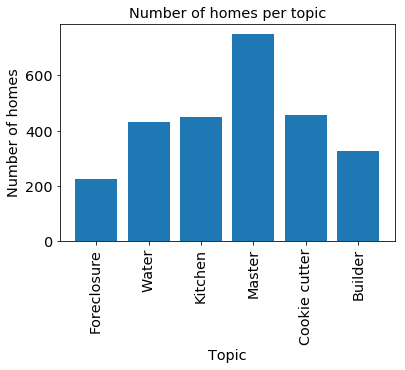

In [728]:
# barplot of marriage rating grouped by affair (True or False)
plt.bar(range(ntopics), counts)
plt.title('Number of homes per topic')
plt.xlabel('Topic')
plt.ylabel('Number of homes')
plt.xticks(range(ntopics), names, rotation='vertical');

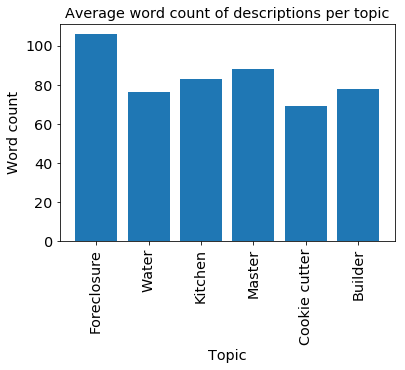

In [729]:
# barplot of marriage rating grouped by affair (True or False)
plt.bar(range(ntopics), df_1_means.word_count)
plt.title('Average word count of descriptions per topic')
plt.xlabel('Topic')
plt.ylabel('Word count')
plt.xticks(range(ntopics), names, rotation='vertical');

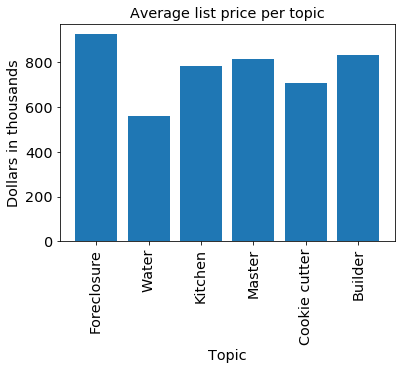

In [730]:
# barplot of marriage rating grouped by affair (True or False)
plt.bar(range(ntopics), df_1_means.price/1000)
plt.title('Average list price per topic')
plt.xlabel('Topic')
plt.ylabel('Dollars in thousands')
plt.xticks(range(ntopics), names, rotation='vertical');

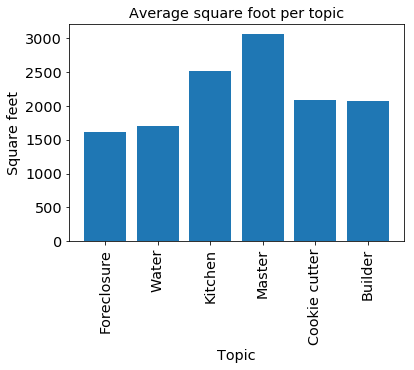

In [731]:
# barplot of marriage rating grouped by affair (True or False)
plt.bar(range(ntopics), df_1_means.sqft)
plt.title('Average square foot per topic')
plt.xlabel('Topic')
plt.ylabel('Square feet')
plt.xticks(range(ntopics), names, rotation='vertical');

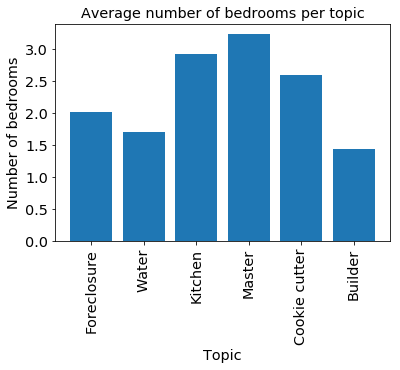

In [732]:
# barplot of marriage rating grouped by affair (True or False)
plt.bar(range(ntopics), df_1_means.bedrooms)
plt.title('Average number of bedrooms per topic')
plt.xlabel('Topic')
plt.ylabel('Number of bedrooms')
plt.xticks(range(ntopics), names, rotation='vertical');

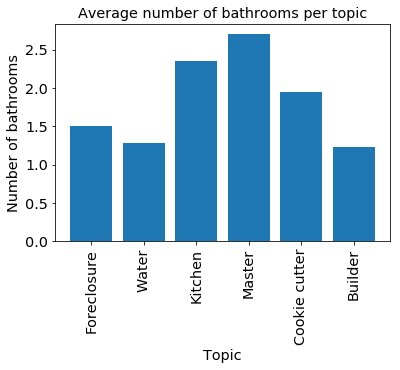

In [733]:
# barplot of marriage rating grouped by affair (True or False)
plt.bar(range(ntopics), df_1_means.bathrooms)
plt.title('Average number of bathrooms per topic')
plt.xlabel('Topic')
plt.ylabel('Number of bathrooms')
plt.xticks(range(ntopics), names, rotation='vertical');

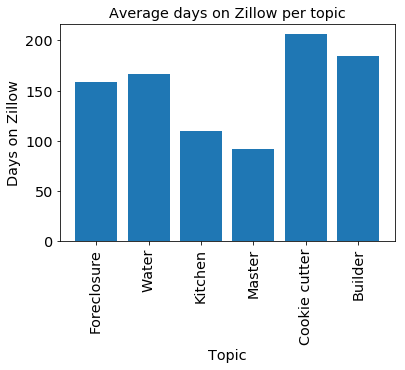

In [734]:
# barplot of marriage rating grouped by affair (True or False)
plt.bar(range(ntopics), df_1_means.days_on_zillow)
plt.title('Average days on Zillow per topic')
plt.xlabel('Topic')
plt.ylabel('Days on Zillow')
plt.xticks(range(ntopics), names, rotation='vertical');

In [735]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2), 
                                   stop_words='english',
                                   max_df = .1,
                                   token_pattern="\\b[a-z][a-z]+\\b")
count_vectorizer.fit(desc)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.1, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
        tokenizer=None, vocabulary=None)

In [736]:
counts = count_vectorizer.transform(desc).transpose()

In [737]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(counts)

In [738]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [739]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=ntopics, minimum_probability=.03, id2word=id2word, passes=10, random_state = 100)

2018-03-08 16:12:21,210 : INFO : using symmetric alpha at 0.16666666666666666
2018-03-08 16:12:21,214 : INFO : using symmetric eta at 0.16666666666666666
2018-03-08 16:12:21,229 : INFO : using serial LDA version on this node
2018-03-08 16:12:23,420 : INFO : running online (multi-pass) LDA training, 6 topics, 10 passes over the supplied corpus of 2639 documents, updating model once every 2000 documents, evaluating perplexity every 2639 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-08 16:12:23,469 : INFO : PROGRESS: pass 0, at document #2000/2639
2018-03-08 16:12:26,854 : INFO : merging changes from 2000 documents into a model of 2639 documents
2018-03-08 16:12:27,301 : INFO : topic #0 (0.167): 0.003*"auction" + 0.003*"com" + 0.002*"properties" + 0.002*"auction com" + 0.002*"sale" + 0.002*"details" + 0.001*"city" + 0.001*"vaulted" + 0.001*"foreclosure" + 0.001*"end"
2018-03-08 16:12:27,304 : INFO : topic #3 (0.167): 0.002*"properties" + 0.002*"sale" + 0.002*"a

2018-03-08 16:12:42,077 : INFO : topic #1 (0.167): 0.002*"shop" + 0.002*"office" + 0.001*"plenty" + 0.001*"island" + 0.001*"bonus" + 0.001*"floor plan" + 0.001*"wood" + 0.001*"fully" + 0.001*"high" + 0.001*"entertaining"
2018-03-08 16:12:42,079 : INFO : topic #5 (0.167): 0.005*"square" + 0.004*"foot" + 0.004*"bathrooms" + 0.004*"square foot" + 0.004*"single" + 0.003*"bedrooms bathrooms" + 0.003*"single family" + 0.003*"home bedrooms" + 0.003*"family home" + 0.003*"bathrooms located"
2018-03-08 16:12:42,083 : INFO : topic #2 (0.167): 0.016*"properties" + 0.014*"auction" + 0.013*"sale" + 0.012*"com" + 0.012*"auction com" + 0.006*"details" + 0.006*"foreclosure" + 0.004*"search" + 0.004*"scheduled" + 0.004*"scheduled sale"
2018-03-08 16:12:42,086 : INFO : topic #0 (0.167): 0.002*"vaulted" + 0.002*"walk closet" + 0.001*"perfect" + 0.001*"upstairs" + 0.001*"main floor" + 0.001*"tub" + 0.001*"island" + 0.001*"doors" + 0.001*"family room" + 0.001*"pantry"
2018-03-08 16:12:42,091 : INFO : topic

2018-03-08 16:12:56,609 : INFO : topic #0 (0.167): 0.002*"walk closet" + 0.001*"vaulted" + 0.001*"upstairs" + 0.001*"perfect" + 0.001*"doors" + 0.001*"tub" + 0.001*"main floor" + 0.001*"hardwood" + 0.001*"island" + 0.001*"dining room"
2018-03-08 16:12:56,611 : INFO : topic diff=0.196340, rho=0.369623
2018-03-08 16:12:58,078 : INFO : -9.810 per-word bound, 897.5 perplexity estimate based on a held-out corpus of 639 documents with 52948 words
2018-03-08 16:12:58,079 : INFO : PROGRESS: pass 5, at document #2639/2639
2018-03-08 16:12:58,442 : INFO : merging changes from 639 documents into a model of 2639 documents
2018-03-08 16:12:58,604 : INFO : topic #0 (0.167): 0.002*"walk closet" + 0.002*"vaulted" + 0.001*"upstairs" + 0.001*"perfect" + 0.001*"island" + 0.001*"doors" + 0.001*"family room" + 0.001*"tub" + 0.001*"bonus" + 0.001*"main floor"
2018-03-08 16:12:58,606 : INFO : topic #1 (0.167): 0.002*"shop" + 0.002*"plenty" + 0.001*"office" + 0.001*"island" + 0.001*"bonus" + 0.001*"floor plan

2018-03-08 16:13:08,539 : INFO : topic #5 (0.167): 0.004*"square" + 0.004*"foot" + 0.004*"bathrooms" + 0.004*"square foot" + 0.003*"bedrooms bathrooms" + 0.003*"single" + 0.003*"single family" + 0.003*"home bedrooms" + 0.003*"family home" + 0.003*"bathrooms located"
2018-03-08 16:13:08,542 : INFO : topic #4 (0.167): 0.002*"bonus" + 0.002*"rm" + 0.002*"great room" + 0.002*"outdoor" + 0.002*"island" + 0.002*"pantry" + 0.002*"cabinets" + 0.002*"wood" + 0.001*"tub" + 0.001*"like"
2018-03-08 16:13:08,544 : INFO : topic #0 (0.167): 0.002*"walk closet" + 0.001*"vaulted" + 0.001*"upstairs" + 0.001*"perfect" + 0.001*"doors" + 0.001*"tub" + 0.001*"hardwood" + 0.001*"island" + 0.001*"main floor" + 0.001*"bonus"
2018-03-08 16:13:08,546 : INFO : topic diff=0.144056, rho=0.311294
2018-03-08 16:13:09,964 : INFO : -9.749 per-word bound, 860.5 perplexity estimate based on a held-out corpus of 639 documents with 52948 words
2018-03-08 16:13:09,965 : INFO : PROGRESS: pass 8, at document #2639/2639
2018-0

In [740]:
lda.print_topics()

2018-03-08 16:13:14,355 : INFO : topic #0 (0.167): 0.002*"walk closet" + 0.002*"upstairs" + 0.001*"vaulted" + 0.001*"perfect" + 0.001*"island" + 0.001*"doors" + 0.001*"bonus" + 0.001*"family room" + 0.001*"tub" + 0.001*"hardwood"
2018-03-08 16:13:14,359 : INFO : topic #1 (0.167): 0.002*"shop" + 0.002*"plenty" + 0.001*"bonus" + 0.001*"office" + 0.001*"island" + 0.001*"floor plan" + 0.001*"fully" + 0.001*"wood" + 0.001*"rv" + 0.001*"schools"
2018-03-08 16:13:14,362 : INFO : topic #2 (0.167): 0.017*"properties" + 0.014*"auction" + 0.013*"sale" + 0.013*"com" + 0.012*"auction com" + 0.006*"details" + 0.006*"foreclosure" + 0.004*"search" + 0.004*"scheduled" + 0.004*"scheduled sale"
2018-03-08 16:13:14,369 : INFO : topic #3 (0.167): 0.003*"build" + 0.002*"building" + 0.002*"ready" + 0.002*"dream" + 0.002*"waterfront" + 0.001*"dream home" + 0.001*"city" + 0.001*"boat" + 0.001*"walking" + 0.001*"downtown"
2018-03-08 16:13:14,373 : INFO : topic #4 (0.167): 0.002*"bonus" + 0.002*"rm" + 0.002*"gre

[(0,
  '0.002*"walk closet" + 0.002*"upstairs" + 0.001*"vaulted" + 0.001*"perfect" + 0.001*"island" + 0.001*"doors" + 0.001*"bonus" + 0.001*"family room" + 0.001*"tub" + 0.001*"hardwood"'),
 (1,
  '0.002*"shop" + 0.002*"plenty" + 0.001*"bonus" + 0.001*"office" + 0.001*"island" + 0.001*"floor plan" + 0.001*"fully" + 0.001*"wood" + 0.001*"rv" + 0.001*"schools"'),
 (2,
  '0.017*"properties" + 0.014*"auction" + 0.013*"sale" + 0.013*"com" + 0.012*"auction com" + 0.006*"details" + 0.006*"foreclosure" + 0.004*"search" + 0.004*"scheduled" + 0.004*"scheduled sale"'),
 (3,
  '0.003*"build" + 0.002*"building" + 0.002*"ready" + 0.002*"dream" + 0.002*"waterfront" + 0.001*"dream home" + 0.001*"city" + 0.001*"boat" + 0.001*"walking" + 0.001*"downtown"'),
 (4,
  '0.002*"bonus" + 0.002*"rm" + 0.002*"great room" + 0.002*"outdoor" + 0.002*"island" + 0.002*"pantry" + 0.002*"cabinets" + 0.002*"perfect" + 0.002*"wood" + 0.002*"tub"'),
 (5,
  '0.005*"square" + 0.004*"foot" + 0.004*"bathrooms" + 0.004*"square

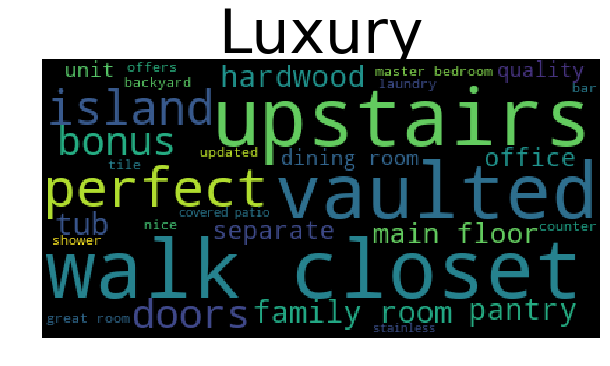

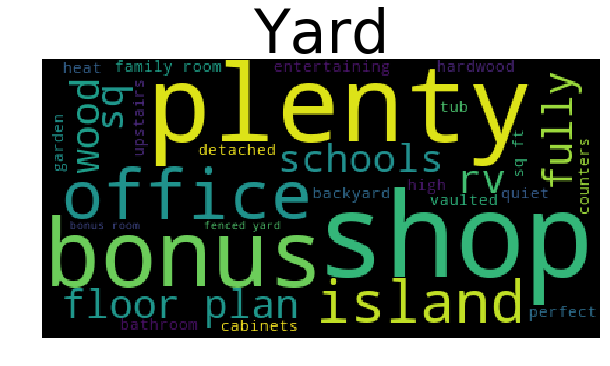

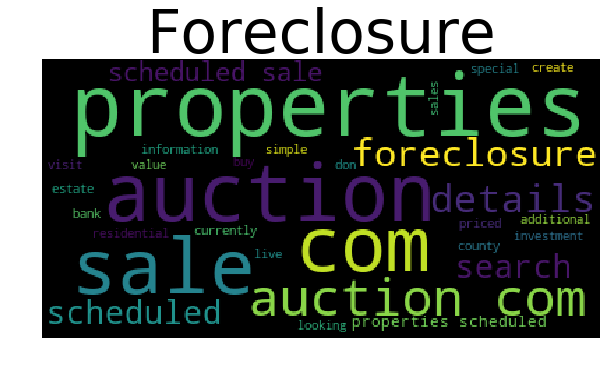

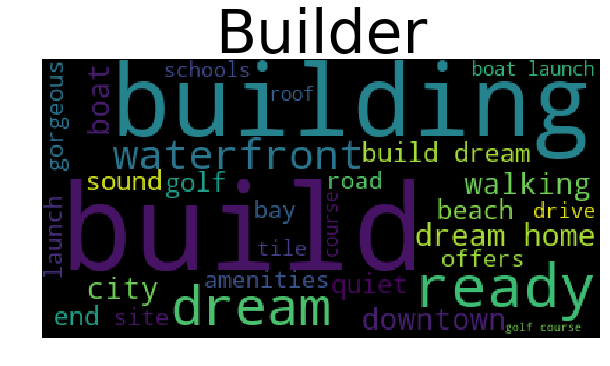

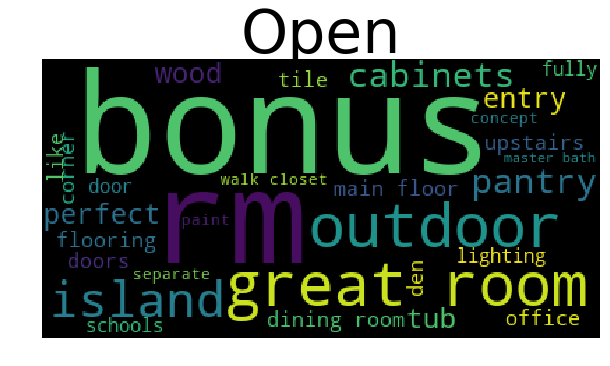

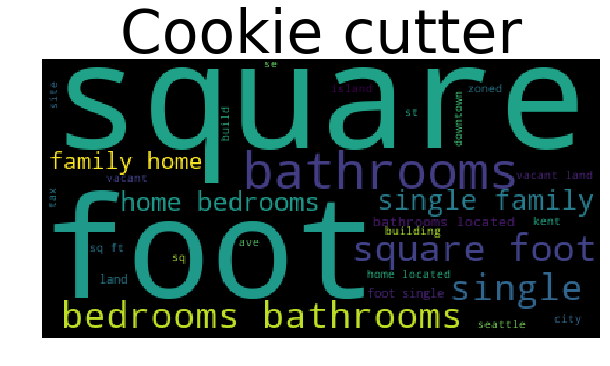

In [741]:
num_words = 30 # Number of words to include in word cloud
names = ['Luxury', 'Yard', 'Foreclosure', 'Builder', 'Open', 'Cookie cutter']
for t in range(lda.num_topics):
    plt.figure(figsize=(10,8))
    plt.imshow(WordCloud().fit_words(dict(lda.show_topic(t, num_words))))
    plt.axis("off")
    plt.title(names[t], fontsize = 60)
    plt.show()

## Topic names:

1 = luxury

2 = yard

3 = foreclosure

4 = builder

5 = open

6 = cookie cutter

In [742]:
lda_corpus = lda[corpus]
lda_corpus

In [743]:
topic_prob = [doc for doc in lda_corpus]

In [744]:
topic_list = []
i = 0
for doc in topic_prob:
    p_old = 0
    for topic in doc:
        t = topic[0]
        p = topic[1]
        if p > p_old:
            p_old = p
            t_take = t
    topic_list.append(t_take)

In [745]:
topic_list

[5,
 0,
 2,
 4,
 1,
 3,
 4,
 5,
 1,
 5,
 1,
 3,
 3,
 3,
 1,
 3,
 0,
 5,
 2,
 3,
 0,
 0,
 2,
 4,
 3,
 3,
 3,
 3,
 1,
 0,
 5,
 0,
 0,
 5,
 5,
 3,
 5,
 2,
 2,
 3,
 2,
 1,
 1,
 5,
 4,
 1,
 3,
 2,
 3,
 2,
 5,
 5,
 0,
 0,
 0,
 0,
 2,
 0,
 5,
 0,
 3,
 0,
 3,
 3,
 1,
 5,
 4,
 3,
 5,
 5,
 3,
 3,
 5,
 0,
 2,
 0,
 2,
 1,
 3,
 4,
 0,
 3,
 3,
 0,
 2,
 0,
 0,
 3,
 4,
 4,
 4,
 3,
 2,
 4,
 5,
 2,
 0,
 0,
 1,
 1,
 2,
 3,
 4,
 2,
 0,
 5,
 1,
 5,
 5,
 3,
 0,
 2,
 0,
 1,
 1,
 5,
 0,
 3,
 1,
 5,
 3,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 0,
 5,
 5,
 5,
 1,
 0,
 1,
 3,
 1,
 1,
 5,
 4,
 1,
 0,
 1,
 4,
 4,
 5,
 3,
 2,
 4,
 3,
 2,
 5,
 5,
 5,
 3,
 5,
 5,
 0,
 3,
 5,
 5,
 0,
 1,
 5,
 0,
 2,
 4,
 5,
 5,
 0,
 1,
 4,
 5,
 5,
 1,
 4,
 0,
 4,
 1,
 4,
 3,
 3,
 3,
 0,
 3,
 5,
 1,
 3,
 1,
 1,
 2,
 1,
 5,
 4,
 1,
 5,
 1,
 2,
 2,
 2,
 0,
 0,
 2,
 4,
 3,
 2,
 3,
 3,
 4,
 3,
 3,
 2,
 1,
 0,
 3,
 1,
 3,
 5,
 1,
 3,
 2,
 2,
 1,
 4,
 1,
 4,
 3,
 4,
 4,
 5,
 1,
 2,
 3,
 5,
 3,
 5,
 1,
 3,
 0,
 4,
 2,
 3,
 5,
 4,
 2,
 5,
 2,
 1,
 3,
 0,


In [746]:
df_2 = df

In [747]:
df_2['topic'] = topic_list

In [748]:
df_2.head()

,address,city,state,zip,price,sqft,bedrooms,bathrooms,days_on_zillow,sale_type,url,description,word_count,topic
0,20014 59th Ave SE,Snohomish,WA,98296,1868000.0,7359.0,4.0,6.0,0.0,House For Sale,http://www.zillow.com/homes/for_sale//homedeta...,Walk-through Video: www.seetheproperty.com/250...,209,5
1,13506 70th Dr SE,Snohomish,WA,98296,674950.0,2957.0,4.0,3.0,3.0,House For Sale,http://www.zillow.com/homes/for_sale//homedeta...,Wonderful Highlands East home that has been up...,91,0
2,14313 214th St SE,Snohomish,WA,98296,546000.0,2237.0,3.0,3.0,6.0,Auction,http://www.zillow.com/homes/for_sale//homedeta...,Investor opportunity! This property is being o...,187,2
3,11621 60th Ave SE,Snohomish,WA,98296,489950.0,2213.0,4.0,3.0,4.0,House For Sale,http://www.zillow.com/homes/for_sale//homedeta...,"Newer 4 br, 2.5 bths 2-story backs to greenbel...",79,4
4,13325 81st Ave SE,Snohomish,WA,98296,720000.0,3091.0,4.0,3.0,12.0,House For Sale,http://www.zillow.com/homes/for_sale//homedeta...,Beautiful Murray Franklin re-sale in the desir...,54,1


In [749]:
df_2[['price', 'sqft', 'bedrooms', 'bathrooms','days_on_zillow']] = df_1[['price', 'sqft', 'bedrooms', 'bathrooms','days_on_zillow']].apply(pd.to_numeric, errors = 'coerce')

In [750]:
df_2.fillna(0, inplace=True)

In [751]:
df_2_means = df_2.groupby('topic').mean()
df_2_means.price

topic
0    929316.981221
1    777234.821002
2    638887.207612
3    746794.528067
4    677123.722581
5    756849.597496
Name: price, dtype: float64

In [752]:
counts = df_2.groupby('topic')['description'].count()

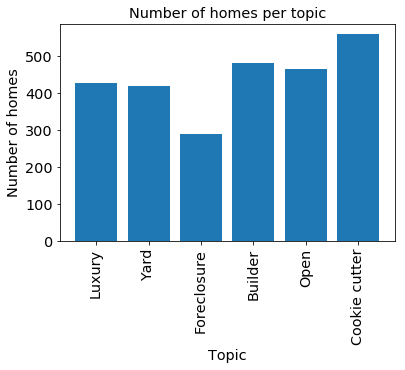

In [753]:
# barplot of marriage rating grouped by affair (True or False)
plt.bar(range(ntopics), counts)
plt.title('Number of homes per topic')
plt.xlabel('Topic')
plt.ylabel('Number of homes')
plt.xticks(range(ntopics), names, rotation='vertical');

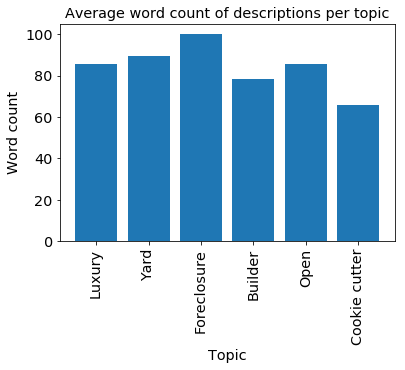

In [754]:
# barplot of marriage rating grouped by affair (True or False)
plt.bar(range(ntopics), df_2_means.word_count)
plt.title('Average word count of descriptions per topic')
plt.xlabel('Topic')
plt.ylabel('Word count')
plt.xticks(range(ntopics), names, rotation='vertical');

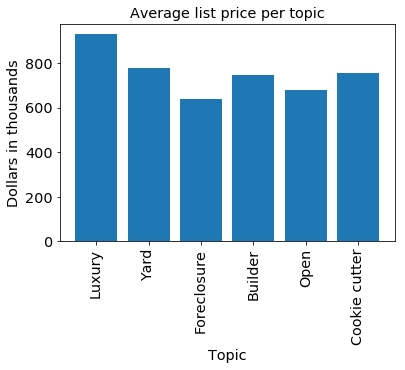

In [755]:
# barplot of marriage rating grouped by affair (True or False)
plt.bar(range(ntopics), df_2_means.price/1000)
plt.title('Average list price per topic')
plt.xlabel('Topic')
plt.ylabel('Dollars in thousands')
plt.xticks(range(ntopics), names, rotation='vertical');

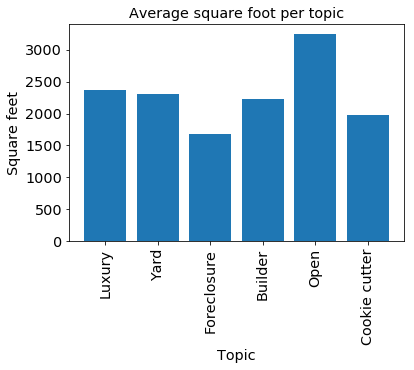

In [756]:
# barplot of marriage rating grouped by affair (True or False)
plt.bar(range(ntopics), df_2_means.sqft)
plt.title('Average square foot per topic')
plt.xlabel('Topic')
plt.ylabel('Square feet')
plt.xticks(range(ntopics), names, rotation='vertical');

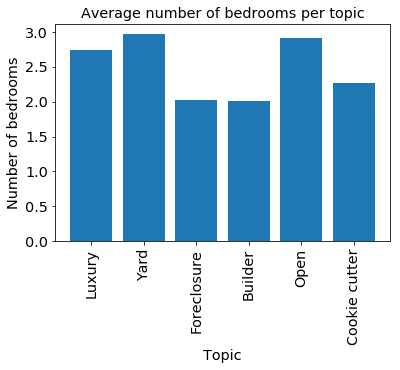

In [757]:
# barplot of marriage rating grouped by affair (True or False)
plt.bar(range(ntopics), df_2_means.bedrooms)
plt.title('Average number of bedrooms per topic')
plt.xlabel('Topic')
plt.ylabel('Number of bedrooms')
plt.xticks(range(ntopics), names, rotation='vertical');

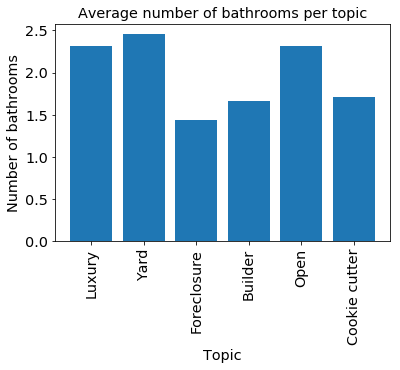

In [758]:
# barplot of marriage rating grouped by affair (True or False)
plt.bar(range(ntopics), df_2_means.bathrooms)
plt.title('Average number of bathrooms per topic')
plt.xlabel('Topic')
plt.ylabel('Number of bathrooms')
plt.xticks(range(ntopics), names, rotation='vertical');

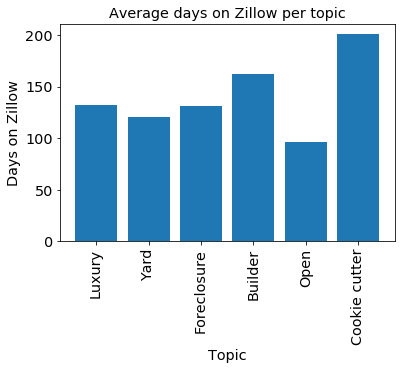

In [759]:
# barplot of marriage rating grouped by affair (True or False)
plt.bar(range(ntopics), df_2_means.days_on_zillow)
plt.title('Average days on Zillow per topic')
plt.xlabel('Topic')
plt.ylabel('Days on Zillow')
plt.xticks(range(ntopics), names, rotation='vertical');

In [858]:
cookie_cutter = df_2[df_2['topic'] == 5]

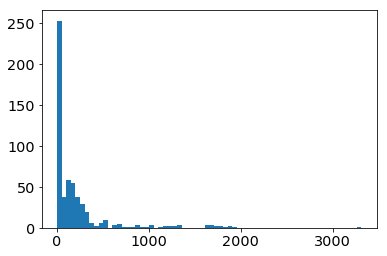

In [865]:
plt.hist(cookie_cutter['days_on_zillow'], bins='auto');

In [866]:
open_ = df_2[df_2['topic'] == 4]

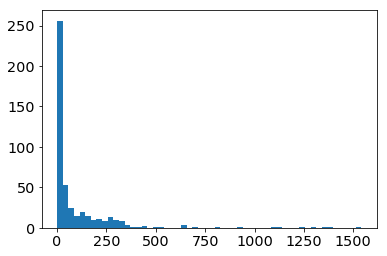

In [869]:
plt.hist(open_['days_on_zillow'], bins='auto');

In [870]:
builder = df_2[df_2['topic'] == 3]

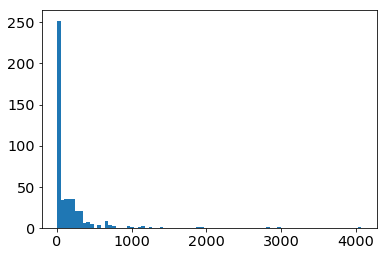

In [871]:
plt.hist(builder['days_on_zillow'], bins='auto');

In [872]:
foreclosure = df_2[df_2['topic'] == 2]

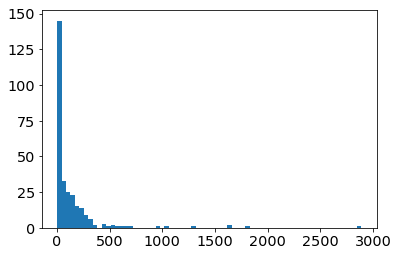

In [874]:
plt.hist(foreclosure['days_on_zillow'], bins='auto');

In [875]:
yard = df_2[df_2['topic'] == 1]

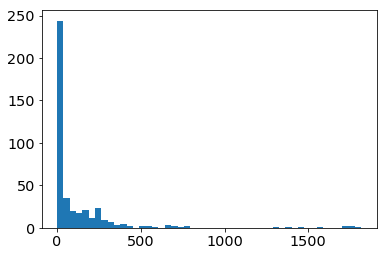

In [876]:
plt.hist(yard['days_on_zillow'], bins='auto');

In [877]:
luxury = df_2[df_2['topic'] == 0]

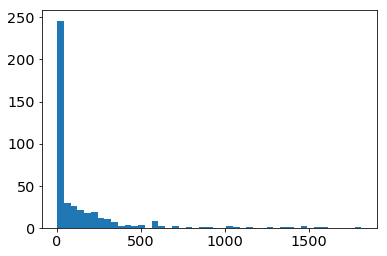

In [878]:
plt.hist(luxury['days_on_zillow'], bins='auto');

In [364]:
import os
import gensim

# Setup nltk corpora path and Google Word2Vec location


In [365]:
all_desc = " ".join(desc)
all_desc = all_desc.split(" ")

In [762]:
# Build corpus from 
import os
from nltk.corpus import stopwords

stop = stopwords.words('english')
stop+=['?','!','.',',',':',';']

#creating our iterator
texts = [[word for word in document.lower().split() if word not in stop]
         for document in desc]

# An Illustration.. 


model = gensim.models.Word2Vec(texts, size=100, window=5, min_count=3, workers=2,sg=1)

2018-03-09 10:24:06,396 : INFO : collecting all words and their counts
2018-03-09 10:24:06,397 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-03-09 10:24:06,438 : INFO : collected 19565 word types from a corpus of 155127 raw words and 2639 sentences
2018-03-09 10:24:06,440 : INFO : Loading a fresh vocabulary
2018-03-09 10:24:06,466 : INFO : min_count=3 retains 5731 unique words (29% of original 19565, drops 13834)
2018-03-09 10:24:06,467 : INFO : min_count=3 leaves 138788 word corpus (89% of original 155127, drops 16339)
2018-03-09 10:24:06,492 : INFO : deleting the raw counts dictionary of 19565 items
2018-03-09 10:24:06,495 : INFO : sample=0.001 downsamples 40 most-common words
2018-03-09 10:24:06,497 : INFO : downsampling leaves estimated 130077 word corpus (93.7% of prior 138788)
2018-03-09 10:24:06,520 : INFO : estimated required memory for 5731 words and 100 dimensions: 7450300 bytes
2018-03-09 10:24:06,523 : INFO : resetting layer weights
2018-03

In [763]:
model.train(texts, total_examples=len(texts), epochs=10)

2018-03-09 10:24:08,596 : WARNING : Effective 'alpha' higher than previous training cycles
2018-03-09 10:24:08,599 : INFO : training model with 2 workers on 5731 vocabulary and 100 features, using sg=1 hs=0 sample=0.001 negative=5 window=5
2018-03-09 10:24:08,977 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 10:24:08,994 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-09 10:24:08,995 : INFO : EPOCH - 1 : training on 155127 raw words (130020 effective words) took 0.4s, 331689 effective words/s
2018-03-09 10:24:09,358 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 10:24:09,372 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-09 10:24:09,373 : INFO : EPOCH - 2 : training on 155127 raw words (129984 effective words) took 0.4s, 347584 effective words/s
2018-03-09 10:24:09,730 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-09 10:24:09,746 : INFO : wo

(1300414, 1551270)

In [772]:
model.most_similar('shopping',topn=10)

/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('freeway,', 0.8393696546554565),
 ('shopping,', 0.81558758020401),
 ('schools,', 0.8097829818725586),
 ('boeing,', 0.8024526834487915),
 ('centers', 0.7927318811416626),
 ('hospitals,', 0.7919293642044067),
 ('commuter', 0.7918799519538879),
 ('i-90,', 0.791269063949585),
 ('microsoft,', 0.7906543016433716),
 ('ez', 0.7815881967544556)]

In [773]:
model.most_similar('foreclosure',topn=10)

/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('auctions', 0.8826045393943787),
 ('sales,', 0.8704015016555786),
 ('bank-owned', 0.8664684295654297),
 ('exclusively', 0.8430256247520447),
 ('31', 0.8422940969467163),
 ('107', 0.8374423980712891),
 ('62', 0.8360229730606079),
 ('majority', 0.8349625468254089),
 ('online', 0.8292865753173828),
 ('focused', 0.8255977630615234)]

In [777]:
model.similarity('law', 'mother')

/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.8863568050461355

In [855]:
model.most_similar('waterfront',topn=10)

/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('quintessential', 0.6511261463165283),
 ('retreat,', 0.649676501750946),
 ('pt.', 0.6468250155448914),
 ('sandy', 0.6385730504989624),
 ('no-bank', 0.6336111426353455),
 ('ranch.', 0.6332683563232422),
 ('drive,', 0.6264640092849731),
 ('waterfront.', 0.6220495700836182),
 ('150', 0.6219643354415894),
 ('beachfront', 0.6199095845222473)]

In [804]:
df.loc[0][10]

'http://www.zillow.com/homes/for_sale//homedetails/20014-59th-Ave-SE-Snohomish-WA-98296/80386855_zpid/'

In [844]:
from functools import reduce
from operator import itemgetter
'''This function will take in a word in the form of a string and
the number of listings the user would like to recieve and return
the descriptions as well as the url of the zillow property.  This
function is used as an advanced search function where the user can
type in a key word they would like to be most related to the properties
they are searching.  For example one might be more interested in
properties with a view, so they would type view and the number of 
properties they would like to see and this function would return
a list of descriptions containing words most correlated to the word
view.'''

def find_listing(word, num_results):
    #Find the documents that contain words that are similar to the passed word.
    #Keep their similarity score along with a copy of the document.
    properties = []
    sim_words = model.most_similar(word, topn=10)
    for doc in desc:
        prob_list = []
        for item in sim_words:
            if item[0] in doc.lower():
                prob_list.append(item[1])
            if item[0] == sim_words[-1][0]:
                    properties.append([prob_list, doc])
    #Sum the similarity scores for each document.             
    listings = []        
    for probs in properties:
        if len(probs[0]) > 1:
            listings.append([reduce(lambda x,y: x+y, list(probs[0])), probs[1]])
    #Sort the similarity scores for each document by most similar first.
    sorted_listings = sorted(listings, reverse=True, key=itemgetter(0))
    #Get the url of the zillow page for each document 
    listings_with_url = []
    for item in sorted_listings:
        i = 0
        for description in df['description']:
            if item[1] == description:
                listings_with_url.append([item, df.loc[i][10]])
            i = i + 1
    #Return only the highest rated documents, number depends on a user specified amount         
    top = listings_with_url[:num_results]
    top_results = []
    for item in top:
        top_results.append([item[0][1], item[1]])
        
    return top_results

In [880]:
find_listing('view', 5)

/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """


[['Top of Cougar Mountain! Potential for 9 lot short plat with 50% open space. 20000sf average lot size. Spectacular view property adjoins Cougar Mountain Wildland Regional Park. Partial clearing has opened up dramatic views from east Bellevue to Lake Sammamish, Mt Baker, Issaquah Highlands and Mt Si. Includes 2 tax parcels (19.99 and 7.73 acres), totaling 27.72 acres. Survey, topography and preliminary short plat drawing available. Award Winning Issaquah Schools.',
  'http://www.zillow.com/homes/for_sale//homedetails/18500-SE-65th-Pl-Issaquah-WA-98027/2107184051_zpid/'],
 ['Top of Cougar Mtn! Spectacular view property adjoins Cougar Mtn Wildland Regional Park. Partial clearing has opened up dramatic views from east Bellevue to Lake Sammamish,Mt Baker,Issaquah Highlands & Mt Si. Survey and topo available. Award Winning Issaquah Schools.',
  'http://www.zillow.com/homes/for_sale//homedetails/185-SE-65th-Pl-Issaquah-WA-98027/2091443356_zpid/'],
 ["Stunning masterpiece on 510ft of Belling

In [371]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_df=.1)

In [372]:
matrix = tfidf.fit_transform(desc)

In [373]:
def get_cluster_centers(X, labels, k_num):
    CC_list = []
    for k in range(k_num):
        # get the mean coordinates of each cluster
        CC_list.append(np.mean(X[labels == k], axis = 0))
    return CC_list

# for each cluster substract the mean from each data point to get the error
# then get the magnitude of each error, square it, and sum it
def get_SSE(X, labels):
    k_num = len(np.unique(labels))
    CC_list = get_cluster_centers(X, labels, k_num)
    CSEs = []
    for k in range(k_num):
        # for each cluster of k we get the coordinates of how far off each point is to the cluster
        error_cords = X[labels == k] - CC_list[k]
        # square the coordinates and sum to get the magnitude squared
        error_cords_sq = error_cords ** 2
        error_mag_sq = np.sum(error_cords_sq, axis = 1)
        # since we already have the magnitude of the error squared we can just take the sum for the cluster
        CSE = np.sum(error_mag_sq)
        CSEs.append(CSE)
    # sum each cluster's sum of squared errors
    return sum(CSEs)

In [374]:
SSEs = []
Sil_coefs = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(matrix)
    labels = km.labels_
    Sil_coefs.append(metrics.silhouette_score(matrix, labels, metric='cosine'))
                                            # could have just said km.inertia_

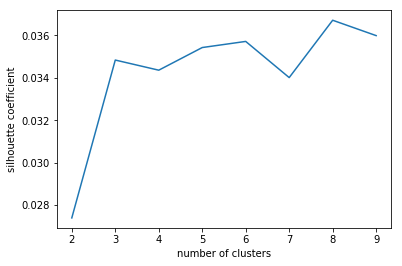

In [375]:
k_clusters = range(2,10)
plt.plot(k_clusters, Sil_coefs);
plt.xlabel('number of clusters');
plt.ylabel('silhouette coefficient');

In [376]:
kmeans = KMeans(n_clusters = 8)

In [377]:
model = kmeans.fit(matrix)

In [378]:
model.cluster_centers_[0]

array([0.00014866, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])